In [1]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys
import matplotlib.pyplot as plt

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
#from fun_objective_loop_manywalls_GeoClaw impo

output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=100)
    print(total_cost_new)
    return total_cost_new

def objective3(x_input, numiter = 100):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=numiter)
    return total_cost_new, wall_cost, n_cost_direct_sum_div

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]




C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


The GISSR method takes in a flood time history along the coast of lower Manhattan. The flood height along the coast varies with time but is specified beforehand as an input and is assumed to be constant along the length of the coast. GISSR then redistributes the water over the area of lower manhattan using ... and calculates the resulting damage cost. .... Below is a

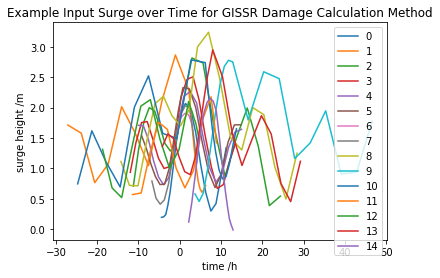

In [24]:
for i in range(15):
    surge_w_example = np.loadtxt('SurgeData/%d-waterlevel_w.csv'%i,skiprows = 1,delimiter = ',')
    times_w_example = np.loadtxt('SurgeData/%d-time_w.csv'%i,skiprows = 1, delimiter = ',')
    plt.plot(times_w_example[0,:],surge_w_example[0,:], label = str(i))
plt.xlabel('time /h')
plt.ylabel('surge height /m')
plt.title('Example Input Surge over Time for GISSR Damage Calculation Method')
plt.legend()
plt.show()


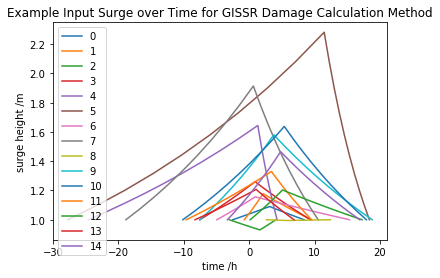

In [7]:
for i in range(15):
    surge_c_example = np.loadtxt('SurgeData/%d-surge_c.csv'%i,skiprows = 1,delimiter = ',')
    times_c_example = np.loadtxt('SurgeData/%d-time_c.csv'%i,skiprows = 1, delimiter = ',')
    plt.plot(times_c_example[0,:],surge_c_example[0,:], label = str(i))
plt.xlabel('time /h')
plt.ylabel('surge height /m')
plt.title('Example Input Surge over Time for GISSR Damage Calculation Method')
plt.legend()
plt.show()


When returning the total damage cost, there 

In [26]:
all_walls_array = np.load('all_walls_array.npy')
all_walls_div_array = np.load('all_walls_div_array.npy')
print(all_walls_array.shape)
print('start, end, height, total cost, wall cost')
print(all_walls_div_array.shape)

(1520, 5)
start, end, height, total cost, wall cost
(1520, 100, 18)


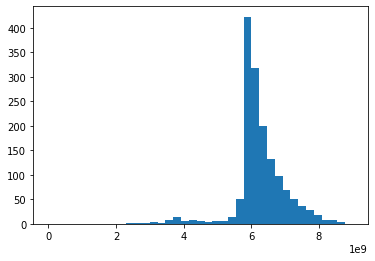

In [54]:
bins = np.linspace(0,9e9,40)
plt.hist(all_walls_array[:,3], bins = bins)
plt.show()

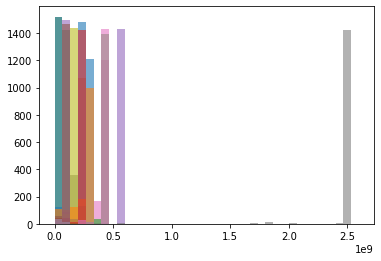

In [42]:
bins = np.linspace(0,2.6e9,40)
for i in range(18):
    plt.hist(np.mean(all_walls_div_array[:,:,i], axis = 1),alpha = 0.6, bins = bins)
    #plt.show()

# Histograms of damage cost for 100 simulations (80 year period of storms), by division 

Histograms of damage cost for 100 storms, by division
No wall:
damage cost 5.853187676374288
total cost  5.853187676374288
wall cost   0.0


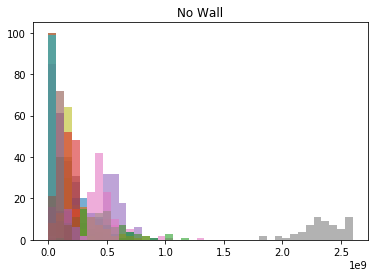

No budget optimal wall:
damage cost 0.45419682232838915
total cost  2.4472828223283893
wall cost   1.993086


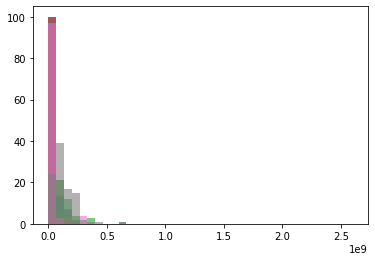

$1B budget optimal wall:
damage cost 5.809926745539627
total cost  6.683439745539627
wall cost   0.873513


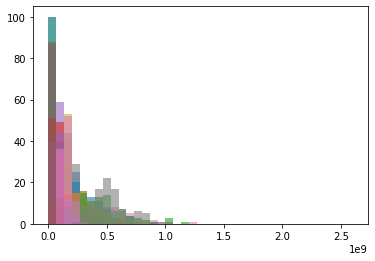

8 part different heights optimal wall:
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
damage cost 1.3349606189067706
total cost  2.3200208196121426
wall cost   0.9850602007053718


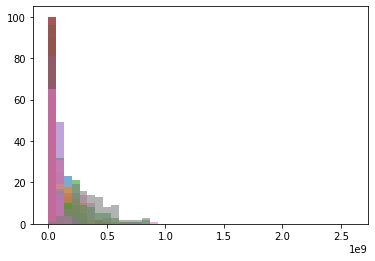

In [70]:
print('Histograms of damage cost for 100 storms, by division')

print('No wall:')
index = 0
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))
      
bins = np.linspace(0,2.6e9,40)
for i in range(18):
    plt.hist(all_walls_div_array[index,:,i],alpha = 0.6, bins = bins)
plt.ylabel = 'frequency'
plt.xlabel = 'damage cost /$'
plt.title('No Wall')
plt.show()

print('No budget optimal wall:')
index = 164
print('damage cost ' + str((all_walls_array[index,3]-all_walls_array[index,4])/1e9))
print('total cost  ' + str(all_walls_array[index,3]/1e9))
print('wall cost   ' + str(all_walls_array[index,4]/1e9))

for i in range(18):
    plt.hist(all_walls_div_array[index,:,i],alpha = 0.6, bins = bins)
plt.show()

print('$1B budget optimal wall:')
budget = 1e9
satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
bmindex = np.argmin(satisfy[:,3])
satisfy_div = all_walls_div_array[all_walls_array[:,4]<=budget,:,:]

print('damage cost ' + str((satisfy[index,3]-satisfy[index,4])/1e9))
print('total cost  ' + str(satisfy[index,3]/1e9))
print('wall cost   ' + str(satisfy[index,4]/1e9))

for i in range(18):
    plt.hist(satisfy_div[bmindex,:,i],alpha = 0.6, bins = bins)
plt.show()

print('8 part different heights optimal wall:')
testwall = np.array([2.16666667,1.33333333,2.16666667,0.16666667,0.83333333,1.0,2.0,1.16666667])
print(testwall)

print('damage cost ' + str((2320020819.6121426-985060200.7053719)/1e9))
print('total cost  ' + str(2320020819.6121426/1e9))
print('wall cost   ' + str(985060200.7053719/1e9))

wall8_div_array = np.load('wall8partsdivarray.npy')
for i in range(18):
    plt.hist(wall8_div_array[:,i],alpha = 0.6, bins = bins)
plt.show()





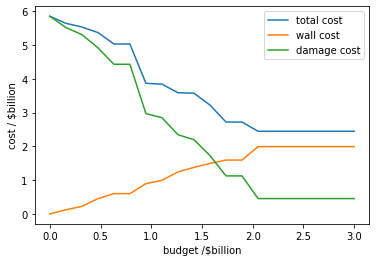

In [65]:
total_cost_list = []
wall_cost_list = []
damage_cost_list = []
budgets = np.linspace(0,3e9,20)
for budget in budgets:
    satisfy = all_walls_array[all_walls_array[:,4]<=budget,:]
    bmindex = np.argmin(satisfy[:,3])
    total_cost_list.append(satisfy[bmindex,3]/1e9)
    wall_cost_list.append(satisfy[bmindex,4]/1e9)
    damage_cost_list.append(satisfy[bmindex,3]/1e9-satisfy[bmindex,4]/1e9)
    
plt.plot(budgets/1e9,total_cost_list, label = 'total cost')
plt.plot(budgets/1e9,wall_cost_list, label = 'wall cost')
plt.plot(budgets/1e9,damage_cost_list, label = 'damage cost')
plt.ylabel('cost / $billion')
plt.xlabel('budget /$billion')
plt.legend()
plt.show()

In [52]:
B = 5e8
if np.sum(np.sum(all_walls_div_array[164,:,:] < B, axis = 0) > 95) == 18:
    print('satisfy')
print(np.sum(all_walls_div_array[164,:,:] < B, axis = 0) > 95)

satisfy
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [53]:
print(all_walls_array[164,3])

2447282822.328389


In [ ]:
for i in range(15)

ideas and to-dos
input geoclaw data into GISSR. see if we can vary location around wall as boundary condition. not single height
sensitivity to input storms

notions of fairness:
area 17 or whatever it is gets inundated super easily. to do with topography? you can check this. 
it requires higher wall. is this fair?
consider not just economic cost but social factors as constraint




### make surge data from geoclaw runs:

In [9]:
num_files = 130
num_gauges = 10

In [10]:
outputs = []
for i in range(num_files):
    print(i)
    gauge_data = []
    for j in range(num_gauges):
        address = '../../../nyc-storm-surge-dataset/outputs/'+format(i,'04d')+'_output/gauge'+format(j+1,'05d')+'.txt'
        gauge_data.append(np.loadtxt(address,skiprows =3))
    outputs.append(gauge_data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129


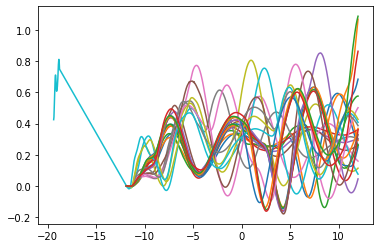

In [13]:
for i in range(24):
    g1 = outputs[i][0]
    plt.plot(g1[g1[:,0]==5,1]/3600,g1[g1[:,0]==5,5])

43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43187.93
43191.95
43187.93
43187.93


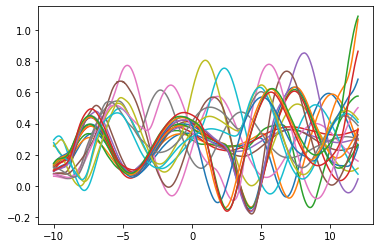

In [34]:
SurgeDataGeo = []
timing_matrix = []
for i in range(24):
    g1 = outputs[i][0]
    show = g1[:,1]>-36000
    SurgeDataGeo.append(np.interp(times, g1[show,1]/3600, g1[show,5]))
    plt.plot(g1[show,1]/3600,g1[show,5])
    print(g1[-1,1])
    timing_matrix.append(times)

In [19]:
times = np.linspace(-10,12,20)

In [18]:
43191/3600

11.9975

In [35]:
SurgeDataGeo = np.array(SurgeDataGeo)
timing_matrix = np.array(timing_matrix)

In [38]:
print(SurgeDataGeo.shape)
print(timing_matrix)

(24, 20)
[[-10.          -8.84210526  -7.68421053  -6.52631579  -5.36842105
   -4.21052632  -3.05263158  -1.89473684  -0.73684211   0.42105263
    1.57894737   2.73684211   3.89473684   5.05263158   6.21052632
    7.36842105   8.52631579   9.68421053  10.84210526  12.        ]
 [-10.          -8.84210526  -7.68421053  -6.52631579  -5.36842105
   -4.21052632  -3.05263158  -1.89473684  -0.73684211   0.42105263
    1.57894737   2.73684211   3.89473684   5.05263158   6.21052632
    7.36842105   8.52631579   9.68421053  10.84210526  12.        ]
 [-10.          -8.84210526  -7.68421053  -6.52631579  -5.36842105
   -4.21052632  -3.05263158  -1.89473684  -0.73684211   0.42105263
    1.57894737   2.73684211   3.89473684   5.05263158   6.21052632
    7.36842105   8.52631579   9.68421053  10.84210526  12.        ]
 [-10.          -8.84210526  -7.68421053  -6.52631579  -5.36842105
   -4.21052632  -3.05263158  -1.89473684  -0.73684211   0.42105263
    1.57894737   2.73684211   3.89473684   5.05263

In [32]:
peak = np.max(SurgeDataGeo,axis = 1)
peak = peak.reshape(-1,1)

In [33]:
print(peak)

[[0.59010308]
 [0.56409741]
 [0.5768437 ]
 [0.37855894]
 [0.42006248]
 [0.48443859]
 [0.7163195 ]
 [0.58895213]
 [0.73758417]
 [0.71773134]
 [0.63371111]
 [0.632597  ]
 [0.6181966 ]
 [0.60860734]
 [0.80318852]
 [0.68683371]
 [0.72699495]
 [0.60437037]
 [0.64803856]
 [0.62846972]
 [0.6853476 ]
 [1.069873  ]
 [1.08944   ]
 [0.8644782 ]]


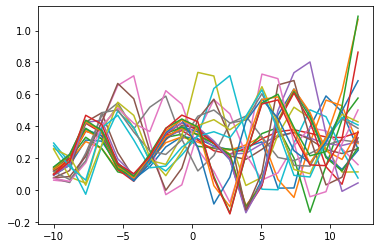

In [40]:
for i in range(24):
    plt.plot(timing_matrix[i,:],SurgeDataGeo[i,:])

In [43]:
np.save('SurgeDataGeo/0-peak_w.npy',peak)
np.save('SurgeDataGeo/0-waterlevel_w.npy',SurgeDataGeo)
np.save('SurgeDataGeo/0-time_w.npy',timing_matrix)